#  RAG 파이프라인 구축 및 평가

In [1]:
# 필요한 라이브러리 임포트
import os
import json
import pandas as pd
import re
from typing import List, Any, Optional
from datetime import datetime
from tqdm import tqdm
from pathlib import Path

from langchain_community.document_loaders import (
    DirectoryLoader,
    UnstructuredMarkdownLoader,
)
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

# LangSmith 설정
from langchain_teddynote import logging

logging.langsmith("HUMETRO_LOCAL_RAG_EVAL")  # 프로젝트 이름 설정

LangSmith 추적을 시작합니다.
[프로젝트명]
HUMETRO_LOCAL_RAG_EVAL


## 1. 개요
한국 도시철도 역무 지식에 특화된 RAG(Retrieval-Augmented Generation) 시스템.  
naive RAG 워크플로우의 데이터 수집부터 평가까지 전체 과정

- 도시철도 역무 관련 문서를 컨텍스트로 LLM에 활용
- 다양한 로컬 LLM 모델을 평가하여 최적의 성능 비교
- 객관적인 평가 방법론을 통한 모델 성능 측정

## 2. 데이터 로드 및 전처리
### 원본 문서

부산교통공사 운영직 교육 자료(공식, 비공식)
  - 야 너두 역무전문가
  - 역무지식 100제
  - 일타 역무
  - 직원 교육 표준자료

### 문서 전처리

  - 한글 문서를 마크다운 형식으로 변환   
  - hwp5html 라이브러리 활용   
  - hwp -> html -> markdown으로 변환

### 문서 로드
  - 아래의 `load_documents` 함수로 문서를 로드하고
  - `split_documents` 함수로 문서를 분할합니다. (800토큰 기준, 오버랩 100)
  - k=4, min_context_length = 4096


In [2]:
def load_documents(doc_dir: str) -> List[Document]:
    """
    특정 디렉토리에서 마크다운 문서를 로드합니다.

    Args:
        doc_dir: 마크다운 문서가 있는 디렉토리 경로

    Returns:
        문서 리스트
    """
    try:
        # 마크다운 로더 생성
        loader = DirectoryLoader(
            doc_dir,
            glob="*.md",  # 현재폴더의 마크다운만 로드
            loader_cls=UnstructuredMarkdownLoader,
            show_progress=True,
            recursive=False,  # 하위 디렉토리는 검색하지 않음
        )

        # 문서 로드
        documents = loader.load()

        print(f"로드된 문서 수: {len(documents)}")

        # 파일 이름을 metadata에 추가
        for doc in documents:
            if "source" in doc.metadata:
                doc.metadata["filename"] = os.path.basename(doc.metadata["source"])

        return documents

    except Exception as e:
        print(f"문서 로드 중 오류 발생: {e}")
        return []


# 문서 로드 실행
doc_dir = Path("./datasets/final_docs")
documents = load_documents(doc_dir)

100%|██████████| 36/36 [00:02<00:00, 12.33it/s]

로드된 문서 수: 36


In [ ]:
def split_documents(
    documents: List[Document],
    chunk_size: int = 800,
    chunk_overlap: int = 100,
    include_filename_in_content: bool = False,
) -> List[Document]:
    """
    문서를 청크로 분할하면서 파일 이름 정보를 유지합니다.

    Args:
        documents: 분할할 문서 리스트
        chunk_size: 각 청크의 크기(토큰 수)
        chunk_overlap: 인접한 청크 간의 겹치는 토큰 수
        include_filename_in_content: 파일 이름을 본문에도 포함할지 여부

    Returns:
        분할된 문서 청크 리스트
    """
    # 파일 이름을 본문에 포함하는 경우, 새 문서 리스트 생성
    if include_filename_in_content:
        preprocessed_docs = []
        for doc in documents:
            filename = doc.metadata.get("filename", "Unknown")
            new_content = f"파일: {filename}\n\n{doc.page_content}"

            # 새 문서 생성 (메타데이터는 유지)
            new_doc = Document(page_content=new_content, metadata=doc.metadata)
            preprocessed_docs.append(new_doc)

        # 처리할 문서를 전처리된 문서로 교체
        documents = preprocessed_docs

    # 토큰 기반 분할기 생성
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ". ", " ", ""],
    )

    # 문서 분할
    splits = text_splitter.split_documents(documents)

    print(f"원본 문서 수: {len(documents)}, 분할 후 청크 수: {len(splits)}")

    # 청크 길이 통계
    lengths = [len(doc.page_content) for doc in splits]
    if lengths:
        print(
            f"청크 길이 - 평균: {sum(lengths) / len(lengths):.1f}, 최소: {min(lengths)}, 최대: {max(lengths)}"
        )

    return splits


# 문서 분할 실행
splits = split_documents(documents)

## 3. 벡터 데이터베이스 구축
  - retrieveral 과정의 semantic search 에 사용되는 벡터 데이터베이스 구축
  - 범용적인 로컬 벡터 데이터베이스인 chroma 사용
  - 임베딩 모델은 OpenAI 의 text-embedding-3-small 사용
  - 로컬에 저장하여 사용

In [ ]:
def create_embeddings(model_name="text-embedding-3-small"):
    """OpenAI 임베딩 모델을 생성합니다."""
    return OpenAIEmbeddings(model=model_name, dimensions=1536)


def create_vectorstore(
    splits, embeddings, persist_dir, collection_name="rag_documents"
):
    """문서 청크를 임베딩하여 Chroma 벡터스토어에 저장합니다."""
    os.makedirs(persist_dir, exist_ok=True)

    if os.path.exists(os.path.join(persist_dir, "chroma.sqlite3")):
        vectorstore = Chroma(
            persist_directory=persist_dir,
            embedding_function=embeddings,
            collection_name=collection_name,
        )

        print(f"기존 벡터스토어 문서 수: {vectorstore._collection.count()}")

        if splits:
            vectorstore.add_documents(splits)
            vectorstore.persist()
            print(
                f"벡터스토어 업데이트 완료. 총 문서 수: {vectorstore._collection.count()}"
            )
    else:
        vectorstore = Chroma.from_documents(
            documents=splits,
            embedding=embeddings,
            persist_directory=persist_dir,
            collection_name=collection_name,
        )
        vectorstore.persist()
        print(f"벡터스토어 생성 완료. 문서 수: {vectorstore._collection.count()}")

    return vectorstore


def load_vectorstore(persist_dir, embeddings, collection_name="rag_documents"):
    """저장된 Chroma 벡터스토어를 로드합니다."""
    if os.path.exists(os.path.join(persist_dir, "chroma.sqlite3")):
        vectorstore = Chroma(
            persist_directory=persist_dir,
            embedding_function=embeddings,
            collection_name=collection_name,
        )
        print(f"벡터스토어 로드 완료. 문서 수: {vectorstore._collection.count()}")
        return vectorstore
    else:
        print(f"벡터스토어를 찾을 수 없습니다: {persist_dir}")
        return None


# 임베딩 및 벡터스토어 생성
embeddings = create_embeddings()
persist_dir = "vectorstore"
vectorstore = create_vectorstore(
    splits=splits, embeddings=embeddings, persist_dir=persist_dir
)

# 벡터스토어 로드 테스트
loaded_vectorstore = load_vectorstore(persist_dir, embeddings)

## 4. 모델 평가를 위한 합성 데이터셋 생성
  - X_AI 의 Grok-3-beta 및 gpt-4o를 데이터 생성의 기반 LLM으로 활용
  - RAG 시스템의 평가에 널리 사용되는 RAGAS 프레임워크를 활용해서 데이터셋 생성
  - 싱글 홉 질문, 멀티 홉 질문을 7:3 비율로 약 500여개 데이터셋 생성

In [ ]:
from ragas.testset import TestsetGenerator
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset.synthesizers.single_hop.specific import (
    SingleHopSpecificQuerySynthesizer,
)
from ragas.testset.synthesizers.multi_hop.specific import (
    MultiHopSpecificQuerySynthesizer,
)
import nest_asyncio

nest_asyncio.apply()


async def generate_qa_dataset(
    splits, output_path="datasets/synthetic_qa_dataset.csv", num_questions=200
):
    """
    RAGAS를 사용하여 합성 QA 데이터셋을 생성합니다.

    Args:
        splits: 내용에서 질문을 생성할 Document 객체 목록
        output_path: CSV 데이터셋을 저장할 경로
        num_questions: 생성할 질문 수

    Returns:
        생성된 데이터셋이 담긴 Pandas DataFrame
    """
    # LLM 및 임베딩 래퍼 초기화
    llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
    embeddings = LangchainEmbeddingsWrapper(
        OpenAIEmbeddings(model="text-embedding-3-small")
    )

    # TestsetGenerator 생성
    generator = TestsetGenerator(llm=llm, embedding_model=embeddings)

    # 질문 유형 분포 설정 (SingleHop 70%, MultiHop 30%)
    distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=llm), 0.7),
        (MultiHopSpecificQuerySynthesizer(llm=llm), 0.3),
    ]

    # 한국어로 질문과 답변 생성하도록 프롬프트 변경
    for query, _ in distribution:
        prompts = await query.adapt_prompts(
            "## 매우 중요: **한국어로만 질문과 답변을 생성**, Question and Answer MUST be in KOREAN",
            llm=llm,
        )
        query.set_prompts(**prompts)

    # 테스트셋 생성
    print(f"총 {num_questions}개의 QA 쌍 생성 중...")
    testset = generator.generate_with_langchain_docs(
        documents=splits,
        testset_size=num_questions,
        query_distribution=distribution,
    )

    # DataFrame으로 변환
    test_df = testset.to_pandas()

    # CSV로 저장
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    test_df.to_csv(output_path, index=False)

    print(f"QA 데이터셋 생성 완료: {len(test_df)}개의 질문-답변 쌍")
    print(f"{output_path}에 저장됨")

    return test_df


import asyncio

test_df = asyncio.run(generate_qa_dataset(splits, num_questions=100))

## 5. 영어 데이터셋 한국어 번역
- 생성된 영어 데이터셋을 한국어로 번역하여 도메인에 특화된 평가 데이터셋을 만듭니다.
- RAGAS 프레임워크의 내부 프롬프트로 인해 생성된 영어로 된 질문을 한국어로 배치 번역
- gpt-4o-mini 활용


## 6. 평가 데이터 생성을 위한 RAG chain 구축

### 6.1 체인의 구성요소
 - params <= 4B (int8 quant VRAM <= 32GB>, FP16 VRAM <= 64GB)   
   Runnable on Single Consumer GPU (RTX 4090 32GB)
 - local models 
    - "hyperclovax-seed-text-instruct-1.5b-hf-i1",
    - "kakaocorp.kanana-nano-2.1b-instruct",
    - "exaone-3.5-2.4b-instruct",
    - "qwen/qwen3-4b:free",
    - "google/gemma-3-4b-it:free"  

 - bigger models  
    - "deepseek/deepseek-chat-v3-0324:free", # 685B, OpenSource
    - "gpt-4o-mini", # Baseline, OpenAI, Proprietary Model, known as 8B
 - retriever
    - chroma vector database
    - OpenAI text-embedding-3-small
    - Naive RAG applied
 - rag chain
    - langchain
    - retriever
    - simple RAG Prompt

### 6.2수행과정
1. 합성 데이터셋의 질문을 retriever에 넣어서 컨텍스트를 받아오고
2. 질문과 컨텍스트를 모델에 넣어 답변을 생성하는 과정
3. 생성한 답변 데이터는 추후 평가에 활용됨
4. gpt-4o-mini 모델은 유사 태스크에 범용적으로 활용되는 모델로서 베이스라인 평가 척도로 활용


### 6.3 체인 구축 및 답변생성 코드

In [ ]:
import json
import os
import re
import subprocess
from typing import Any

import pandas as pd
from langchain.vectorstores import Chroma
from langchain_community.llms import Ollama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_teddynote import logging
from tqdm import tqdm

logging.langsmith("HUMETRO_EVAL_TEST")


def create_embeddings(model_name: str = "text-embedding-3-small") -> OpenAIEmbeddings:
    return OpenAIEmbeddings(model=model_name, dimensions=1536)


def load_vectorstore(persist_directory: str, embeddings: Any) -> Chroma:
    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=embeddings,
        collection_name="rag_documents",
    )
    print(f"벡터스토어 로드 완료. 문서 수: {vectorstore._collection.count()}")
    return vectorstore


def create_retriever(vectorstore: Chroma, k: int = 4) -> Any:
    return vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": k})


def create_llm(model_signature: str, temperature: float = 0.1) -> Any:
    OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1"
    local_models = [
        "exaone-3.5-2.4b-instruct",
        "kakaocorp.kanana-nano-2.1b-instruct",
        "hyperclovax-seed-text-instruct-1.5b-hf-i1",
    ]
    open_router_models = [
        "qwen/qwen3-4b:free",
        "google/gemma-3-4b-it:free",
        "deepseek/deepseek-chat-v3-0324:free",
    ]
    if "gpt" in model_signature:
        return ChatOpenAI(model=model_signature, temperature=temperature)
    if model_signature in local_models:
        try:
            subprocess.run(["lms", "unload", "-a"])
            print("모든 lms 언로드 완료")
            subprocess.run(["lms", "load", model_signature])
            print(f"lms 모델 {model_signature} 로드 완료")
            return ChatOpenAI(
                base_url="http://localhost:1234/v1", model=model_signature
            )
        except Exception as e:
            print(f"lms 명령 실행 중 오류 발생: {e}")
            print("lms가 설치되어 있고 실행 중인지 확인하세요.")
    if model_signature in open_router_models:
        llm = ChatOpenAI(
            openai_api_key=os.getenv("OPENROUTER_API_KEY"),
            openai_api_base=OPENROUTER_BASE_URL,
            model_name=model_signature,
            temperature=temperature,
        )
        return llm
    return None


# 5. RAG 체인 생성 함수
def create_rag_chain(llm: Any, retriever: Any) -> Any:
    # 한국의 역무환경을 고려한 RAG 프롬프트 템플릿
    template = """
당신은 한국의 도시철도 역무 지식 도우미입니다.
주어진 질문에 대해 제공된 문맥 정보를 기반으로 정확하고 도움이 되는 답변을 제공하세요.
문맥에 없는 내용은 답변하지 마세요. 모르는 경우 솔직히 모른다고 말하세요.

문맥 정보:
{context}

질문: {question}

답변:
"""

    prompt = ChatPromptTemplate.from_template(template)

    def format_docs(docs):
        return "\n\n".join([doc.page_content for doc in docs])

    # LCEL을 사용한 RAG 체인 정의
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    return rag_chain


def sanitize_filename(filename):
    filename.replace(".json", "")
    return re.sub(r"[^a-zA-Z0-9_.]", "_", filename)[:30] + ".json"


if __name__ == "__main__":
    target_models = [
        "qwen/qwen3-4b:free",
        "google/gemma-3-4b-it:free",
        "deepseek/deepseek-chat-v3-0324:free",
        "hyperclovax-seed-text-instruct-1.5b-hf-i1",
        "kakaocorp.kanana-nano-2.1b-instruct",
        "exaone-3.5-2.4b-instruct",
        "gpt-4o-mini",
    ]
    embeddings = create_embeddings()
    vectorstore = load_vectorstore(
        persist_directory="vectorstore", embeddings=embeddings
    )
    if len(vectorstore.similarity_search("서울역 주변 명소")) == 0:
        raise ValueError("vectorstore is empty")
    if len(vectorstore.get()["ids"]) == 0:
        raise ValueError("vectorstore is empty")

    # 질문 데이터 불러오기
    question_data = pd.read_csv("./dataset_200.csv")
    base_questions = list(question_data["user_input"])
    print(base_questions[:10])

    for model_signature in target_models:
        try:
            print(f"Loading {model_signature}...")
            llm = create_llm(model_signature)
            retriever = create_retriever(vectorstore)
            rag_chain = create_rag_chain(llm, retriever)
            filename = sanitize_filename(f"result_{model_signature}.json")
            try:
                with open(filename, "r") as f:
                    result_list = json.load(f)
            except FileNotFoundError:
                result_list = []

            # 이미 처리된 질문 제외
            processed_question = [i["question"] for i in result_list]
            target_questions = [
                i for i in base_questions if i not in processed_question
            ]

            for question in tqdm(
                target_questions, desc=f"Evaluating {model_signature}"
            ):
                try:
                    result = rag_chain.invoke(question)
                    result_list.append({"question": question, "answer": result})
                    if len(result_list) % 10 == 0:  # 10개마다 저장하기
                        print(f"checkpoint, saved {len(result_list)}")
                    with open(filename, "w") as f:
                        json.dump(result_list, f, ensure_ascii=False)
                except Exception as e:
                    print(
                        f"Error: while generating {model_signature} single question {question}: {e}"
                    )
                    continue
            with open(filename, "w") as f:  # 최종 결과 저장하기
                json.dump(result_list, f, ensure_ascii=False)
        except Exception as e:
            print(f"Error: while generating {model_signature}: {e}")
            continue


### 6.4 답변 생성 결과
langsmith 플랫폼을 활용하여 모니터링

https://smith.langchain.com/o/06d0a329-b301-5d27-b5a2-94923e9bb6c0/projects

## 7. RAGAS의 기본 평가 메트릭을 적용한 평가 결과

### 7.1 생성 데이터 후처리

In [ ]:
from langchain_teddynote import logging

logging.langsmith("HUMETRO_EVAL_TEST")


source_df = pd.read_csv(dataset_dir / "ragas_200_with_model_answers.csv")
eval_datasets = {}

for f in qa_data_files:
    dataset = []
    model_name = f.name.replace("result_", "").replace(".json", "")
    print("Create Eval Dataset for ", model_name)
    success_count = 0
    error_list = set()

    for item in source_df.to_dict("records"):
        debug_var = item["reference_outputs"]
        dataset.append(
            {
                "user_input": item["user_input"],
                "retrieved_contexts": [item["reference_outputs"]],
                "response": item[model_name],
                "reference": item["reference"],
            }
        )
    eval_datasets[model_name] = dataset

### 7.2 평가를 위한 LLM 정의
 - gpt-4.1
   - API 코스트 이슈
   - 7개 모델 200개 질문, 2개 메트릭, 메트릭당 4회 호출 (11,000회)
 - grok-3-beta
    - 무료 크레딧 보유  
    - 크레딧 사용량  
    <img src="/Users/sdh/Dev/projects/humetro-ai-assistant/grok_usage_cropped.png" width="500">

In [ ]:
## 7.2
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas import EvaluationDataset

from langchain_openai import ChatOpenAI
from langchain_xai import ChatXAI
from langchain_openai import OpenAIEmbeddings

llm = ChatOpenAI(model="gpt-4.1-2025-04-14")
llm = ChatXAI(model="grok-3-beta")
embeddings = OpenAIEmbeddings()
# testing llm response
response = llm.invoke("hello").content
print(response)


### 7.3 RAGAS의 기본 메트릭을 활용한 평가 수행
#### 메트릭 소개
0. Heuristic Metrics
  - BLUE
  - ROUGE
2. FactualCorrectness
  -  응답이 **레퍼런스 응답**과 얼마나 사실적으로 일치하는지를 측정.
  -  레퍼런스 응답은 합성자료 생성시 만든 **정답**으로서의 답변을 의미
3. Faithfulness
  - 응답이 **컨텍스트로 주어진 문서**와 얼마나 일치하는지를 측정.
  - 응답 생성시 Retrieval 과정에서 사용된 컨텍스트를 의미
  - 질문과 코사인 유사도를 활용한 의미적으로 가장 가까운 문서들의 집합

In [ ]:
evaluator_llm = LangchainLLMWrapper(llm)
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness

eval_results = {}
# for key, dataset in eval_datasets.items():
dataset = eval_datasets["qwen_qwen3_4b_free"]
key = "qwen_qwen3_4b_free"
try:
    print(f"Evaluating {key}...")
    evaluation_dataset = EvaluationDataset.from_list(dataset)
    result = evaluate(
        dataset=evaluation_dataset,
        metrics=[Faithfulness(), FactualCorrectness()],
        llm=evaluator_llm,
    )
    print(key, "data_size", len(evaluation_dataset), " -> ", result)
    eval_results[key] = result
except Exception as e:
    print(f"Error evaluating {key}: {e}")
    eval_results[key] = None

with open("eval_results_200_grok.json", "w") as f:
    json.dump(eval_results, f)

#### 7.3.1 평가 결과

In [2]:
{
    "hyperclovax_seed_text_1.5b": {
        "faithfulness": 0.3661,
        "factual_correctness(mode=f1)": 0.302,
    },
    "kakaocorp.kanana_nano_2.1b": {
        "faithfulness": 0.4089,
        "factual_correctness(mode=f1)": 0.3714,
    },
    "exaone_3.5_2.4b_instruc": {
        "faithfulness": 0.4023,
        "factual_correctness(mode=f1)": 0.371,
    },
    "google_gemma_3_4b_it_fr": {
        "faithfulness": 0.5984,
        "factual_correctness(mode=f1)": 0.4223,
    },
    "qwen_qwen3_4b_free": {
        "faithfulness": 0.509,
        "factual_correctness(mode=f1)": 0.4147,
    },
    "deepseek_deepseek_chat_": {
        "faithfulness": 0.5682,
        "factual_correctness(mode=f1)": 0.44,
    },
    "gpt_4o_mini": {"faithfulness": 0.6388, "factual_correctness(mode=f1)": 0.4881},
}


{'hyperclovax_seed_text_1.5b': {'faithfulness': 0.3661,
  'factual_correctness(mode=f1)': 0.302},
 'kakaocorp.kanana_nano_2.1b': {'faithfulness': 0.4089,
  'factual_correctness(mode=f1)': 0.3714},
 'exaone_3.5_2.4b_instruc': {'faithfulness': 0.4023,
  'factual_correctness(mode=f1)': 0.371},
 'google_gemma_3_4b_it_fr': {'faithfulness': 0.5984,
  'factual_correctness(mode=f1)': 0.4223},
 'qwen_qwen3_4b_free': {'faithfulness': 0.509,
  'factual_correctness(mode=f1)': 0.4147},
 'deepseek_deepseek_chat_': {'faithfulness': 0.5682,
  'factual_correctness(mode=f1)': 0.44},
 'gpt_4o_mini': {'faithfulness': 0.6388,
  'factual_correctness(mode=f1)': 0.4881}}

### 7.4 메트릭 평가 기준
1. Thresholds
- Deep Eval Threshold (https://www.deepeval.com/docs/metrics-ragas)
  -  DeepEval에서의 임계값: DeepEval이라는 프레임워크에서는 RagasMetric을 사용할 때 임계값(threshold)을 0.5로 설정.
  -  "합격/불합격" 테스트 케이스를 결정하는 부동 소수점 값을 나타냅니다.
- Evaluation of RAG Metrics for Question Answering in the Telecom Domain(https://arxiv.org/html/2407.12873v1)
  -  텔레콤 도메인 연구에서 제안한 것처럼, 사실적 정확성과 충실성을 함께 사용하면 응답의 품질을 더 잘 평가할 수 있습니다.
  -   두 메트릭 모두에서 적어도 0.7 이상의 점수를 요구
2. Goals
  - baseline score : 0.5 on both metrics
  - target score : 0.7 on both metrics

### 7.5 메트릭 시각화

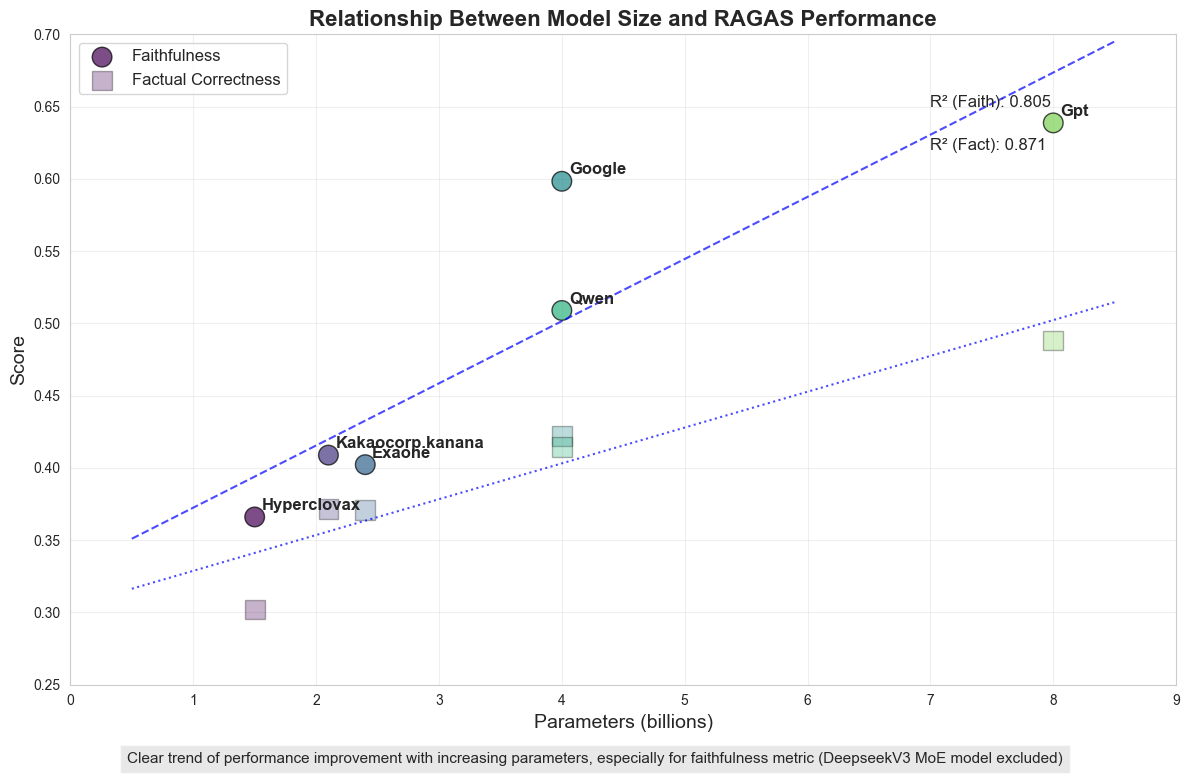

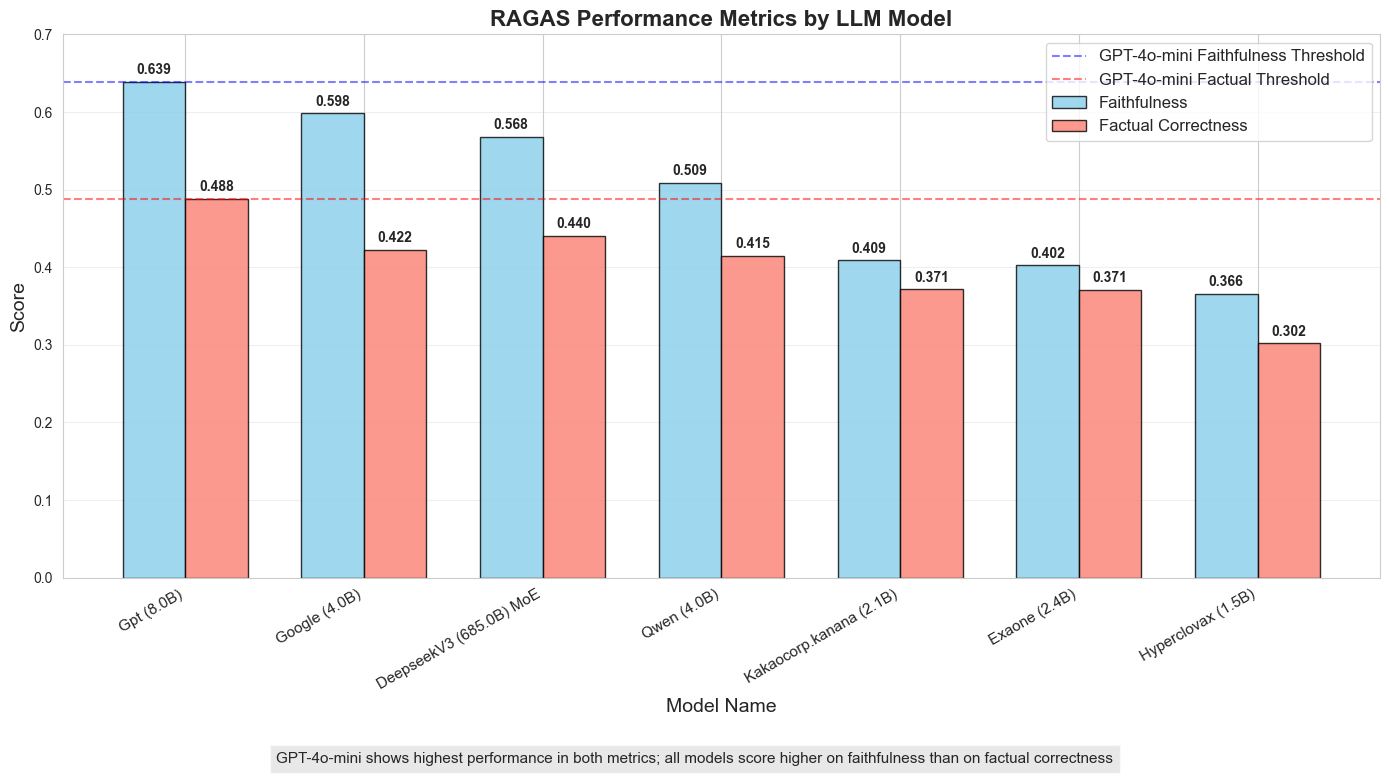

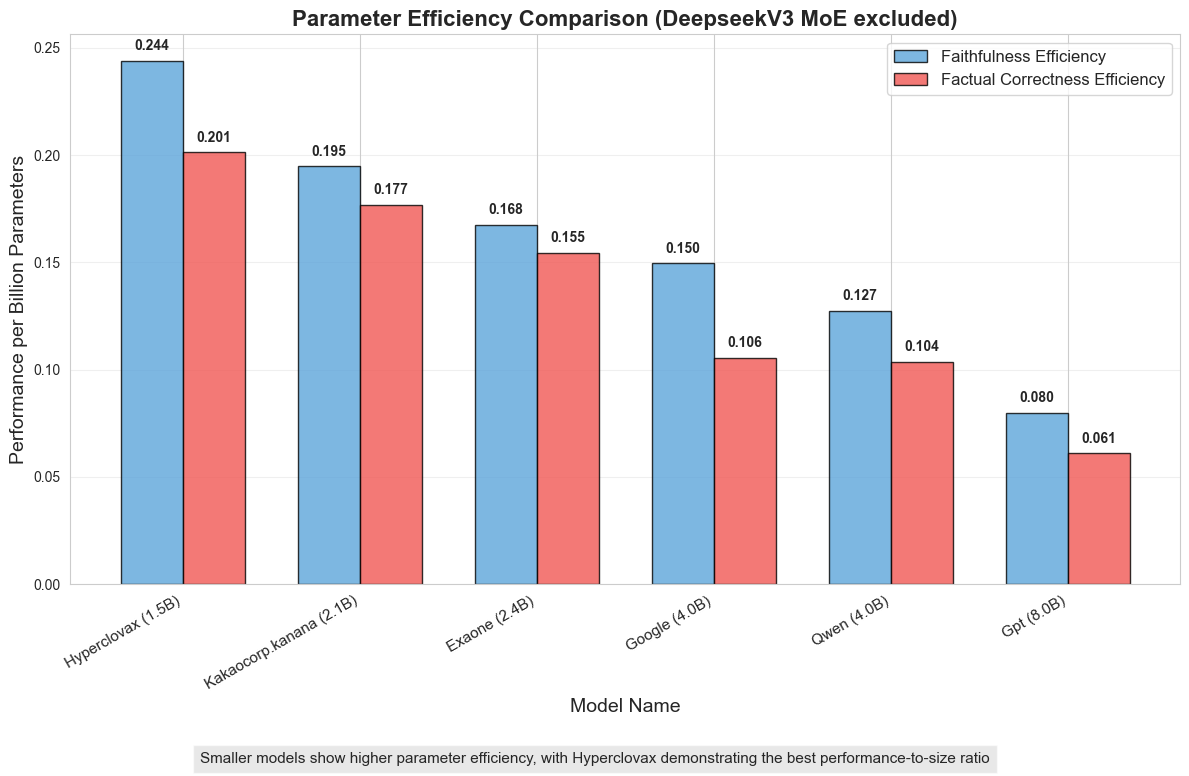

Visualization complete. The relationship between parameter count and performance metrics has been analyzed from multiple perspectives.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import warnings

warnings.filterwarnings("ignore")

# Set matplotlib parameters for better rendering
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 100
mpl.rcParams["axes.unicode_minus"] = False
sns.set_style("whitegrid")

# Data preparation - extract parameter counts from model names
data = {
    "model_name": [
        "hyperclovax_seed_text_1.5b",
        "kakaocorp.kanana_nano_2.1b",
        "exaone_3.5_2.4b_instruc",
        "google_gemma_3_4b_it_fr",
        "qwen_qwen3_4b_free",
        "deepseek_deepseek_chat_",
        "gpt_4o_mini",
    ],
    "params_billion": [
        1.5,
        2.1,
        2.4,
        4.0,
        4.0,
        685.0,
        8.0,
    ],  # deepseek is 685B MoE model, gpt_4o_mini is estimated
    "faithfulness": [0.3661, 0.4089, 0.4023, 0.5984, 0.509, 0.5682, 0.6388],
    "factual_correctness": [0.302, 0.3714, 0.371, 0.4223, 0.4147, 0.44, 0.4881],
}

df = pd.DataFrame(data)

# Add MoE model indicator
df["moe"] = df["model_name"].apply(lambda x: "MoE" if "deepseek" in x else "")

# Add combined performance score
df["combined_score"] = (df["faithfulness"] + df["factual_correctness"]) / 2

# Calculate difference from benchmark (gpt_4o_mini)
benchmark_faith = df.loc[df["model_name"] == "gpt_4o_mini", "faithfulness"].values[0]
benchmark_fact = df.loc[
    df["model_name"] == "gpt_4o_mini", "factual_correctness"
].values[0]

df["faith_diff"] = (df["faithfulness"] - benchmark_faith) / benchmark_faith * 100
df["fact_diff"] = (df["factual_correctness"] - benchmark_fact) / benchmark_fact * 100

# Calculate ratio
df["faith_to_fact_ratio"] = df["faithfulness"] / df["factual_correctness"]

# Simplify model names for display
df["short_name"] = df["model_name"].apply(lambda x: x.split("_")[0].capitalize())
df.loc[df["short_name"] == "Deepseek", "short_name"] = "DeepseekV3"
df["display_name"] = df.apply(
    lambda x: f"{x['short_name']} ({x['params_billion']}B){' ' + x['moe'] if x['moe'] else ''}",
    axis=1,
)

# Sort by performance score
df_sorted = df.sort_values("combined_score", ascending=False).reset_index(drop=True)

# Print data overview
# print(
#     df_sorted[
#         [
#             "display_name",
#             "params_billion",
#             "faithfulness",
#             "factual_correctness",
#             "combined_score",
#             "faith_to_fact_ratio",
#         ]
#     ]
# )

# 1. Parameters vs Performance Scatter Plot (excluding MoE model)
plt.figure(figsize=(12, 8))

# Filter out DeepseekV3 (too large to plot on same scale)
df_no_moe = df[df["moe"] == ""]

# Use consistent colormap
colors = plt.cm.viridis(np.linspace(0, 0.8, len(df_no_moe)))

plt.scatter(
    df_no_moe["params_billion"],
    df_no_moe["faithfulness"],
    s=200,
    c=[colors[i] for i in range(len(df_no_moe))],
    alpha=0.7,
    edgecolor="black",
    label="Faithfulness",
)
plt.scatter(
    df_no_moe["params_billion"],
    df_no_moe["factual_correctness"],
    s=200,
    c=[colors[i] for i in range(len(df_no_moe))],
    alpha=0.3,
    edgecolor="black",
    marker="s",
    label="Factual Correctness",
)

# Add model name labels
for i, row in df_no_moe.iterrows():
    plt.annotate(
        row["short_name"],
        (row["params_billion"], row["faithfulness"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=12,
        fontweight="bold",
    )

plt.title(
    "Relationship Between Model Size and RAGAS Performance",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Parameters (billions)", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xlim(0, 9)
plt.ylim(0.25, 0.7)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add trendlines
from scipy.stats import linregress

slope_faith, intercept_faith, r_faith, p_faith, std_err_faith = linregress(
    df_no_moe["params_billion"], df_no_moe["faithfulness"]
)
slope_fact, intercept_fact, r_fact, p_fact, std_err_fact = linregress(
    df_no_moe["params_billion"], df_no_moe["factual_correctness"]
)

x_line = np.linspace(0.5, 8.5, 100)
plt.plot(x_line, intercept_faith + slope_faith * x_line, "b--", alpha=0.7)
plt.plot(x_line, intercept_fact + slope_fact * x_line, "b:", alpha=0.7)

# Add R² values
plt.text(7, 0.65, f"R² (Faith): {r_faith**2:.3f}", fontsize=12)
plt.text(7, 0.62, f"R² (Fact): {r_fact**2:.3f}", fontsize=12)

# Add explanation note
plt.figtext(
    0.5,
    0.01,
    "Clear trend of performance improvement with increasing parameters, especially for faithfulness metric (DeepseekV3 MoE model excluded)",
    ha="center",
    fontsize=11,
    bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5},
)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# 2. Model Performance Comparison (Bar Chart)
plt.figure(figsize=(14, 8))

x = np.arange(len(df_sorted))
width = 0.35

plt.bar(
    x - width / 2,
    df_sorted["faithfulness"],
    width,
    color="skyblue",
    edgecolor="black",
    alpha=0.8,
    label="Faithfulness",
)
plt.bar(
    x + width / 2,
    df_sorted["factual_correctness"],
    width,
    color="salmon",
    edgecolor="black",
    alpha=0.8,
    label="Factual Correctness",
)

for i, v in enumerate(df_sorted["faithfulness"]):
    plt.text(
        i - width / 2, v + 0.01, f"{v:.3f}", ha="center", fontsize=10, fontweight="bold"
    )

for i, v in enumerate(df_sorted["factual_correctness"]):
    plt.text(
        i + width / 2, v + 0.01, f"{v:.3f}", ha="center", fontsize=10, fontweight="bold"
    )

plt.axhline(
    y=benchmark_faith,
    color="blue",
    linestyle="--",
    alpha=0.5,
    label="GPT-4o-mini Faithfulness Threshold",
)
plt.axhline(
    y=benchmark_fact,
    color="red",
    linestyle="--",
    alpha=0.5,
    label="GPT-4o-mini Factual Threshold",
)

plt.xlabel("Model Name", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.title("RAGAS Performance Metrics by LLM Model", fontsize=16, fontweight="bold")
plt.xticks(x, df_sorted["display_name"], rotation=30, ha="right", fontsize=11)
plt.legend(fontsize=12, loc="upper right")
plt.ylim(0, 0.7)
plt.grid(axis="y", alpha=0.3)

# Add explanation note
plt.figtext(
    0.5,
    0.01,
    "GPT-4o-mini shows highest performance in both metrics; all models score higher on faithfulness than on factual correctness",
    ha="center",
    fontsize=11,
    bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5},
)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()

plt.figure(figsize=(12, 8))

df_no_moe = df[df["moe"] == ""].copy()
df_no_moe["efficiency_faith"] = df_no_moe["faithfulness"] / df_no_moe["params_billion"]
df_no_moe["efficiency_fact"] = (
    df_no_moe["factual_correctness"] / df_no_moe["params_billion"]
)
df_eff = df_no_moe.sort_values("efficiency_faith", ascending=False).reset_index(
    drop=True
)

x = np.arange(len(df_eff))
width = 0.35

plt.bar(
    x - width / 2,
    df_eff["efficiency_faith"],
    width,
    color="#5DA5DA",
    edgecolor="black",
    alpha=0.8,
    label="Faithfulness Efficiency",
)
plt.bar(
    x + width / 2,
    df_eff["efficiency_fact"],
    width,
    color="#F15854",
    edgecolor="black",
    alpha=0.8,
    label="Factual Correctness Efficiency",
)

for i, v in enumerate(df_eff["efficiency_faith"]):
    plt.text(
        i - width / 2,
        v + 0.005,
        f"{v:.3f}",
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

for i, v in enumerate(df_eff["efficiency_fact"]):
    plt.text(
        i + width / 2,
        v + 0.005,
        f"{v:.3f}",
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

plt.xlabel("Model Name", fontsize=14)
plt.ylabel("Performance per Billion Parameters", fontsize=14)
plt.title(
    "Parameter Efficiency Comparison (DeepseekV3 MoE excluded)",
    fontsize=16,
    fontweight="bold",
)
plt.xticks(x, df_eff["display_name"], rotation=30, ha="right", fontsize=11)
plt.legend(fontsize=12)
plt.grid(axis="y", alpha=0.3)

# Add explanation note
plt.figtext(
    0.5,
    0.01,
    "Smaller models show higher parameter efficiency, with Hyperclovax demonstrating the best performance-to-size ratio",
    ha="center",
    fontsize=11,
    bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5},
)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()

print(
    "Visualization complete. The relationship between parameter count and performance metrics has been analyzed from multiple perspectives."
)

### 7.6 결론

#### 0. Personal Contribution
> 석사논문주제에 관한 기본 파이프라인 구축  
> RAG 시스템 구축의 전체 과정에 대한 실습

#### 1. 파라미터 수가 클수록 성능이 일관되게 상승
#### 2. 오픈소스 모델의 가능성 확인 (4B gemma3 모델의 점수는 베이스라인 성능에 근접함)
  - 상용 그래픽카드로 1장만으로도 사용할만한 성능의 RAG 시스템 구축 가능함.
  - 회사 내부 서버에 GPU pooling 또는 공공 클라우드 활용으로 공공기관의 전체 수요에 부응하는 private RAG 시스템 구축 가능함.
#### 3. Naive RAG만을 사용했음
따라서 다음과 같은 기법 적용으로 성능향상이 가능할 것으로 예상됨 
  - GraphRAG
  - hybird search
  - document optimization
#### 4. 향후 구축할 Knowledge Graph와의 관계
  - Knowledge Graph 빌딩
  - KG가 적용된 RAG 시스템 구축
  - 모델 평가 사이클 및 개선
    - 개선 과정에서 부족한 이론지식 및 학습
    - 자연어처리 전반, 트랜스포머, KG, RAG, LLM as a judge 와 같은 주제에 대해서 학습
  - 0.7 이상의 성능을 목표로 RAG 파이프라인 튜닝 및 적절한 모델 선정